# Graph Neural Network
---
> Design and ideas about GNNs for vertex dynamics sim-n

👷**To-Do** 🚧<br>
*Need to change edge,Node, global classes (below)*:
need classes `node`, `edge`, and `cell` , instead of global should process cell-wise features.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from os import path

from torch_geometric.data import Data, DataLoader
from simgnn.datasets import VertexDynamics, CellData
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


Message Passing class:
- The user only has to define the functions 𝜙, i.e. `message()` 💌, and 𝛾 , i.e. `update()` 🔃, as well as the aggregation scheme {**∑**📩} to use, i.e. `aggr="add"`, `aggr="mean"` or `aggr="max"`.
- a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

In [9]:
# test = VertexDynamics('../../../dataDIR/simgnn_data/test/')

In [4]:
# training dataset
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/')
vtxdata

Processing...
Done!


VertexDynamics(95)

In [6]:
data = vtxdata[0]
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [13]:
data.is_undirected()

False

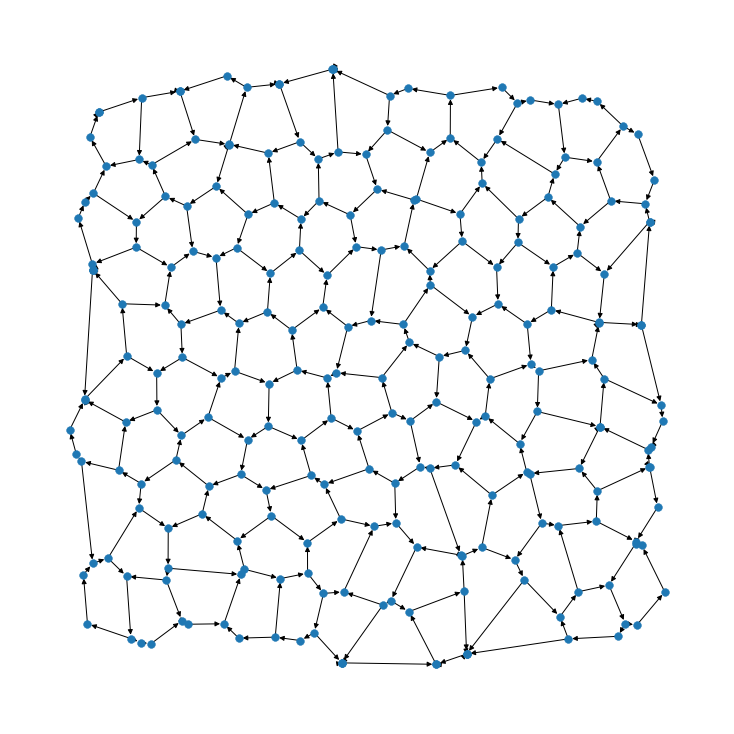

In [15]:
nx.draw(to_networkx(data),pos=dict(enumerate(data.pos.numpy())), node_size=60)

In [11]:
# in order to track the batch id for var-s add its key to "follow_batch":
loader = DataLoader(vtxdata, batch_size=2,follow_batch=['cell_pressures','edge_index'])
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids
batch = next(iter(loader))
batch

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], cell_pressures_batch=[200], edge_index=[2, 1356], edge_index_batch=[1356], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])

In [8]:
# nx.draw(to_networkx(batch, to_undirected=True),pos=dict(enumerate(batch.pos.numpy())), node_size=60)

In [16]:
from simgnn.nn import mlp, EdgeModel

In [5]:
import torch
from torch.nn import Sequential, Linear, ReLU, Dropout
from torch_scatter import scatter_mean, scatter_sum, scatter_max

In [108]:
batch

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], cell_pressures_batch=[200], edge_attr=[1356, 2], edge_index=[2, 1356], edge_index_batch=[1356], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])

In [ ]:
class NodeModel(torch.nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.node_mlp_e = mlp#?
        self.node_mlp_c = mlp#?
        self.node_mlp_update = mlp#?

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

In [ ]:
class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(..., ...), ReLU(), Lin(..., ...))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
        return self.global_mlp(out)


In [ ]:


class MetaLayer(torch.nn.Module):
    r"""A meta layer for building various kinds of graph network layers
    [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

    A graph network takes a graph as input and returns an updated graph as
    output (with same connectivity).
    - The input graph has
        - node features `x`,
        - edge features `edge_attr`, as well as
        - global-level features `u`.
    The output graph has the same structure, but updated features.

    Edge features, node features as well as global features are updated by
    calling the modules `edge_model`, `node_model` and `global_model`, respectively.

    To allow for batch-wise graph processing, all callable functions take an
    additional argument `batch`, which determines the assignment of
    edges or nodes to their specific graphs.

    Args:
        edge_model (Module, optional): A callable which updates a graph's edge
            features based on its source and target node features, its current
            edge features and its global features. (default: `None`)
        node_model (Module, optional): A callable which updates a graph's node
            features based on its current node features, its graph
            connectivity, its edge features and its global features.
            (default: `None`)
        global_model (Module, optional): A callable which updates a graph's
            global features based on its node features, its graph connectivity,
            its edge features and its current global features.

        op = MetaLayer(EdgeModel(), NodeModel(), GlobalModel())
        x, edge_attr, u = op(x, edge_index, edge_attr, u, batch)
    """
    def __init__(self, edge_model=None, node_model=None, global_model=None):
        super(MetaLayer, self).__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model
        
        self.reset_parameters()
    
    def reset_parameters(self):
        for item in [self.node_model, self.edge_model, self.global_model]:
            for m in item.modules():
                if hasattr(m, 'reset_parameters'):
                    m.reset_parameters()
    
    def forward(self, x, edge_index, edge_attr=None, u=None, batch=None):
        """"""
        row, col = edge_index

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[row], x[col], edge_attr, u,
                                        batch if batch is None else batch[row])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, u, batch)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u, batch)

        return x, edge_attr, u
    
    def __repr__(self):
        return ('{}(\n'
                '    edge_model={},\n'
                '    node_model={},\n'
                '    global_model={}\n'
                ')').format(self.__class__.__name__, self.edge_model,
                            self.node_model, self.global_model)